In [1]:
import time 
start = time.time()

# import os
# os.environ["pRT_input_data_path"] = "/home/mvasist/pRT/input_data"

import numpy as np
import pylab as plt
import matplotlib.ticker as mticker

import pymultinest

plt.rcParams['figure.figsize'] = (10, 6)
from petitRADTRANS import Radtrans
from petitRADTRANS import nat_cst as nc 
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.retrieval.models import emission_model_diseq

from sbi.inference import SNRE_A, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi.types import Array, OneOrMore, ScalarFloat

import torch


In [2]:
# Load scattering version of pRT
atmosphere = Radtrans(line_species = ['H2O',
                                      'CO_all_iso',
                                      'CH4',
                                      'NH3',
                                      'CO2',
                                      'H2S',
                                      'VO',
                                      'TiO_all_Exomol', 
#                                       'FeH',
                                      'PH3',
                                      'Na_allard',
                                      'K_allard'],
                      cloud_species = ['MgSiO3(c)_cd',"Fe(c)_cd"],
                      rayleigh_species = ['H2', 'He'],
                      continuum_opacities = ['H2-H2', 'H2-He'],
                      wlen_bords_micron = [0.95, 2.45],
                      do_scat_emis = True)

pressures = np.logspace(-6, 2, 154)
atmosphere.setup_opa_structure(pressures)


  Read line opacities of H2O...
 Done.
  Read line opacities of CO_all_iso...
 Done.
  Read line opacities of CH4...
 Done.
  Read line opacities of NH3...
 Done.
  Read line opacities of CO2...
 Done.
  Read line opacities of H2S...
 Done.
  Read line opacities of VO...
 Done.
  Read line opacities of TiO_all_Exomol...
 Done.
  Read line opacities of PH3...
 Done.
  Read line opacities of Na_allard...
 Done.
  Read line opacities of K_allard...
 Done.

  Read in opacity of cloud species MgSiO3 ...
  Read in opacity of cloud species Fe ...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
 Done.



In [3]:
def Simulator(params): 

    '''
Dictionary of required parameters:
                *  D_pl : Distance to the planet in [cm]
                *  log_g : Log of surface gravity
                *  R_pl : planet radius [cm]
                *  T_int : Interior temperature of the planet [K]
                *  T3 : Innermost temperature spline [K]
                *  T2 : Middle temperature spline [K]
                *  T1 : Outer temperature spline [K]
                *  alpha : power law index in tau = delta * press_cgs**alpha
                *  log_delta : proportionality factor in tau = delta * press_cgs**alpha
                *  sigma_lnorm : Width of cloud particle size distribution (log normal)
                *  log_pquench : Pressure at which CO, CH4 and H2O abundances become vertically constant
                *  Fe/H : Metallicity
                *  C/O : Carbon to oxygen ratio
                *  log_kzz : Vertical mixing parameter
                *  fsed : sedimentation parameter
                *  log_X_cb : Scaling factor for equilibrium cloud abundances.
                
                
Parameter  Value         Parameter                     Value
T 1        330.6 K       log(X_0 Fe /X_eq Fe)          -0.86
T 2        484.7 K       log(X_0 MgSiO3 /X_eq MgSiO3)  -0.65
T 3        687.6 K       fsed                           3
log(δ)     -7.51         log(K zz /cm 2 s −1)           8.5
α          1.39          σg                             2
T 0        1063.6 K      R_P                            1 R J
C/O        0.55          log(g/cm s −2)                 3.75
[Fe/H]     0             log(P quench/bar)             -10 

C/O, Fe/H, log_pquench, XFe, XMgSiO3, fsed, log_kzz, sigma_lnorm, log_g, R_pl,
T_int, T3, T2, T1, alpha, log_delta- Molliere

C/O, Fe/H, log_pquench, XFe, XMgSiO3, log_g, R_pl,
T_int, T3, T2, T1, alpha, log_delta - me

#change the T3, T2, T1 and log delta values in models.py to

T1 = parameters['T1'].value                        ########################new
T2 = parameters['T2'].value                        ########################new
T3 = parameters['T3'].value                        ########################new
delta = 10**parameters['log_delta'].value          ########################new

before running the TABULATED DATA in the paper M2020

'''
    
    #16 params for simulation.
    
    # need to change the params from numpy/float to torch 
    
    CO = params[0].numpy()                 # 0.55
    FeH = params[1].numpy()                # 0.
    log_pquench = params[2].numpy()        # -10.
    XFe = params[3].numpy()                # -0.86
    XMgSiO3 = params[4].numpy()            # -0.65
    fsed = params[5].numpy()               # 3. 
    log_kzz = params[6].numpy()            # 8.5
    sigma_lnorm = params[7].numpy()        # 2.
    log_g = params[8].numpy()              # 3.75
    R_pl = params[9].numpy()               # 1
    T_int = params[10].numpy()             # 1063.6
    T3 = params[11].numpy()                # 687.6 
    T2 = params[12].numpy()                # 484.7 
    T1 = params[13].numpy()                # 330.6 
    alpha = params[14].numpy()             # 1.39
    log_delta = params[15].numpy()         # -7.51
        
    parameters={}
    parameters['D_pl'] = Parameter(name = 'D_pl', is_free_parameter = False, value = 41.2925*nc.pc) 
    parameters['log_g'] = Parameter(name ='log_g',is_free_parameter = False, value = log_g)
    parameters['R_pl'] = Parameter(name = 'R_pl', is_free_parameter = False, value = R_pl* nc.r_jup_mean)
    parameters['T_int'] = Parameter(name ='T_int',is_free_parameter = False, value = T_int)
    parameters['T3'] = Parameter(name = 'T3', is_free_parameter = False, value = T3)
    parameters['T2'] = Parameter(name ='T2',is_free_parameter = False, value = T2)
    parameters['T1'] = Parameter(name = 'T1', is_free_parameter = False, value = T1)
    parameters['alpha'] = Parameter(name ='alpha',is_free_parameter = False, value = alpha)
    parameters['log_delta'] = Parameter(name ='log_delta',is_free_parameter = False, value = log_delta)
    parameters['sigma_lnorm'] = Parameter(name ='sigma_lnorm',is_free_parameter = False, value = sigma_lnorm)
    parameters['log_pquench'] = Parameter(name ='log_pquench',is_free_parameter = False, value = log_pquench)
    parameters['Fe/H'] = Parameter(name ='Fe/H',is_free_parameter = False, value = FeH)
    parameters['C/O'] = Parameter(name ='C/O',is_free_parameter = False, value = CO)
    parameters['log_kzz'] = Parameter(name ='log_kzz',is_free_parameter = False, value = log_kzz)
    parameters['fsed'] = Parameter(name ='fsed',is_free_parameter = False, value = fsed)
    parameters['log_X_cb'+ '_Fe(c)'] = Parameter(name ='log_X_cb'+'_Fe(c)',is_free_parameter = False, value = XFe)
    parameters['log_X_cb'+'_MgSiO3(c)'] = Parameter(name ='log_X_cb'+'_MgSiO3(c)',is_free_parameter = False, value = XMgSiO3)
    parameters['pressure_scaling'] = Parameter(name ='pressure_scaling',is_free_parameter = False, value = 10)
    parameters['pressure_width'] = Parameter(name ='pressure_width',is_free_parameter = False, value = 3)
    parameters['pressure_simple'] = Parameter(name ='pressure_simple',is_free_parameter = False, value = 100)
    
    wlen, flux , p, t = emission_model_diseq(atmosphere, parameters, AMR = True)
    

    #save P_T profile --> csv file 

    p_tensor = torch.Tensor(p)
    t_tensor = torch.Tensor(t)
    p_tensor = p_tensor.unsqueeze(0)
    t_tensor = t_tensor.unsqueeze(0)
    pt = torch.cat((p_tensor, t_tensor), 0)
    torch.save(pt , 'obs_PT.pt')

    flux_tensor = torch.Tensor(flux)    
    
    return flux_tensor 


In [4]:
# obs = Simulator(torch.Tensor([0.55, 0., -10., -0.86, -0.65, 3., 8.5, 2, 3.75, 1., 1063.6, 687.6, 484.7, 330.6, 1.39, -7.51]))

In [5]:
# torch.save(obs, '/home/mvasist/scripts_new/observation/obs.pt')

In [6]:
check = Simulator(torch.Tensor([1.8774e-01,  1.2896e+00, -2.9946e+00,  2.0789e+00, -2.7344e+00, 2.4163e+00, 1.0090e+01,  2.2838e+00,  3.9141e+00,  1.9043e+00, 8.4873e+02,  9.4219e-01,  2.7552e-01,  2.1837e-01, 1.1207e+00, 7.2480e-01])) 

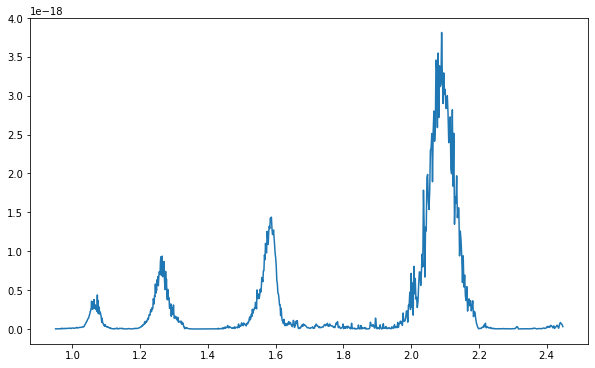

In [12]:
w = torch.load('/home/mvasist/scripts_new/wlen.pt')
plt.plot(w, check)
plt.show()

In [13]:
# pt = torch.load('/home/mvasist/scripts_new/observation/obs_PT.pt')

In [14]:
# plt.plot(pt[1][:143],np.log10(pt[0][:143]))
# plt.gca().invert_yaxis()
# plt.ylim(1,-2)

In [10]:
  #torch.Tensor([ 5.6698e-01, -6.6267e-01, -1.5272e+00, -1.3490e+00,  4.1449e+00,
        #  6.4391e+00,  6.5205e+00,  2.5818e+00,  2.1441e+00,  1.1276e+00,
        #  1.9918e+03,  8.6127e-01,  5.6803e-01,  1.9787e-02,  1.2955e+00,
        #  8.0463e-01]))

In [11]:
# [1.00000000e-06 1.02096066e-06 1.04236067e-06 1.06420924e-06 1.08651577e-06 1.10928986e-06 1.13254132e-06 
# 1.15628013e-06 1.18051653e-06 1.20526094e-06 1.23052400e-06 1.25631660e-06 1.28264983e-06 1.30953502e-06 
# 1.33698374e-06 1.36500781e-06 1.39361927e-06 1.42283046e-06 1.45265393e-06 1.48310251e-06 1.51418933e-06
#  1.54592774e-06 1.57833141e-06 1.61141428e-06 1.64519059e-06 1.67967487e-06 1.71488197e-06 1.75082703e-06
#   1.78752553e-06 1.86324631e-06 2.29276931e-06 2.82130768e-06 3.47168682e-06 4.27199397e-06 5.25679112e-06
#    6.46860766e-06 7.95977700e-06 9.79469667e-06 1.20526094e-05 1.48310251e-05 1.82499324e-05 2.24569800e-05 
#    2.76338529e-05 3.40041193e-05 4.18428851e-05 5.14886745e-05 6.33580499e-05 7.79636013e-05 9.59360829e-05
#     1.18051653e-04 1.45265393e-04 1.78752553e-04 2.19959307e-04 2.70665207e-04 3.33060034e-04 4.09838367e-04
#      5.04315949e-04 6.20572881e-04 7.63629826e-04 9.39664831e-04 1.15628013e-03 1.42283046e-03 1.75082703e-03 
#      2.15443469e-03 2.65108360e-03 3.26222201e-03 4.01424249e-03 4.93962174e-03 6.07832313e-03 7.47952252e-03 
#      9.20373200e-03 1.13254132e-02 1.39361927e-02 1.71488197e-02 2.11020343e-02 2.59665597e-02 3.19524751e-02 
#      3.93182876e-02 4.83820966e-02 5.95353313e-02 7.32596543e-02 9.01477631e-02 1.10928986e-01 1.36500781e-01
#       1.67967487e-01 2.06688025e-01 2.54334576e-01 3.12964801e-01 3.85110700e-01 4.73887961e-01 5.83130511e-01 
#       7.17556092e-01 8.82969996e-01 1.08651577e+00 1.33698374e+00 1.64519059e+00 2.02444651e+00 2.49113003e+00
#        3.06539530e+00 3.77204249e+00 4.64158883e+00 5.71158648e+00 7.02824426e+00 8.64842328e+00 1.06420924e+01
#         1.30953502e+01 1.61141428e+01 1.98288395e+01 2.43998630e+01 3.00246171e+01 3.69460121e+01 4.54629547e+01 
#         5.59432571e+01 6.88395207e+01 8.47086827e+01 1.04236067e+02 1.28264983e+02 1.30953502e+02 1.33698374e+02 
#         1.36500781e+02 1.39361927e+02 1.42283046e+02 1.45265393e+02 1.48310251e+02 1.51418933e+02 1.54592774e+02 
#         1.57833141e+02 1.61141428e+02 1.64519059e+02 1.67967487e+02 1.71488197e+02 1.75082703e+02 1.78752553e+02 
#         1.82499324e+02 1.86324631e+02 1.90230119e+02 1.94217468e+02 1.98288395e+02 2.02444651e+02 2.06688025e+02 
#         2.11020343e+02 2.15443469e+02 2.19959307e+02 2.24569800e+02 2.29276931e+02 2.34082728e+02 2.38989257e+02 
#         2.94082017e+02 3.61874981e+02 4.45295851e+02 5.47947234e+02 6.74262224e+02 8.29695852e+02]
        
        # [  0   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19  20  21  22  24  25  26  27  28  29 
        #  30  31  32  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  
        #  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82 
        #   83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
        #    110 111 112 113 114 115 116 117 118 119 120 122 123 124 125 126 127 128 129 130 131 133 134 135 136 137 138
        #     139 140 141 142 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159]